In [ ]:
import time
import numpy as np
import math
import random
from scipy.optimize import linprog

In [ ]:
class network_top:
  def __init__(self, num_cities,coordinates,b_vec):
    self.num_cities = num_cities
    self.coordinates = coordinates
    self.b_vec=b_vec
    self.distances()

  def distances(self):
    cij_mat=np.zeros((self.num_cities,self.num_cities))
    for i in range(self.num_cities):
      for j in range(self.num_cities):
        cij_mat[i,j]=np.sqrt((self.coordinates[i,0]-self.coordinates[j,0])**2+(self.coordinates[i,1]-self.coordinates[j,1])**2)
    self.cij=cij_mat

def lhs_constraints(n):
  #n - number of cities
  a = []

  ### flow i,j < n-1 ###
  for i in range(n):
    for j in range(n):
      ineqn_mat=np.zeros((n,n))
      ineqn_mat[i,j]=1
      a.append(ineqn_mat.flatten())
  
  ###  sigma(j) flow i,j - sigma(j) flow j,i <= bi ###
  for i in range(n):
    eq_mat = np.zeros((n,n))
    eq_mat[:,i] = -1*np.ones(n)
    eq_mat[i,:] = np.ones(n)
    eq_mat[i,i] = 0
    constr=eq_mat.flatten()
    constr = constr.tolist()
    a.append(constr)
  
  ##  sigma flow i,j - sigma flow j,i >= bi ###
  for i in range(n):
    eq_mat = np.zeros((n,n))
    eq_mat[:,i] = np.ones(n)
    eq_mat[i,:] = -1*np.ones(n)
    eq_mat[i,i] = 0
    constr=eq_mat.flatten()
    constr = constr.tolist()
    a.append(constr)

  ### flow i,i <= 0 ###
  for i in range(n):
    ineqn_mat=np.zeros((n,n)) 
    ineqn_mat[i,i]=1
    constr2=ineqn_mat.flatten()
    constr2 = constr2.tolist()
    a.append(constr2)

  x = np.asarray(a)
  return x

def rhs_constraints(demand,n):
  b = []

  ### flow i,j < n-1 ###
  for i in range(n*n):
    b.append(n-1)
    
  ###  sigma(j) flow i,j - sigma(j) flow j,i <= bi ###
  for i in demand:
    b.append(i)

  ### sigma flow i,j - sigma flow j,i >= bi ###
  for i in demand:
    b.append(-i)

  ### flow i,i <= 0 ###
  for i in range(n):
    b.append(0)

  x = np.asarray(b)
  return x

In [ ]:
import networkx as nx 
import matplotlib.pyplot as plt 
   
class GraphVisualization: 
   
    def __init__(self): 
        self.visual = [] 
          
    def addEdge(self, a, b, c): 
        temp = (a, b, {'weight': c})
        self.visual.append(temp) 
          
    def visualize(self): 
        G = nx.Graph() 
        G.add_edges_from(self.visual) 
    
        pos = nx.spring_layout(G)
        nx.draw_networkx_nodes(G,pos,node_size=700)
        nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')
        nx.draw_networkx_edges(G,pos,edgelist=self.visual, width=6)
        labels = nx.get_edge_attributes(G,'weight')
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
        plt.figure(1,figsize=(25,25))
        plt.show()
def plot(num_cities,weights,flow_mat):
    edges = flow_mat>0
    G = GraphVisualization()
    for i in range(num_cities):
      for j in range(num_cities):
        if(i!=j):
          if(edges[i][j]):
            G.addEdge(i,j,weights[i][j]*flow_mat[i][j])
    G.visualize()

In [ ]:
class Node:
    """
    This class models a node in the branch and bound algorithm.
    flow_var: the solution in node
    obj_func_val: the obj value of node
    """
    def __init__(self, flow_var = None, obj_func_val=None):
      self.flow_var = flow_var
      self.obj_func_val = obj_func_val

In [ ]:
def isInt(list1):
  indices = []
  for i in range(len(list1)):
    if abs(list1[i]-round(list1[i])) > 0.00001:
      return i
    else:
      list1[i] = round(list1[i])

def LeftCons(no_of_var, index): #returns a list
  temp = [0] * no_of_var
  temp[index] = 1
  return temp

def RightCons(no_of_var, index): #returns a list
  temp = [0] * no_of_var
  temp[index] = -1
  return temp

In [ ]:
def bab(A,b,c,prev_flow_val,trac_val, min_or_max): #trac_val tracks the minimum cost while traversing the tree 
      global total
      global list1
      global iter
      global list2

      iter += 1
      n = 1
      if(min_or_max == "max"):
        n = -1
      #t1 = time.time()
      res = linprog(n*c, A_ub=A, b_ub=b)   #simplex method 
      #print(res.x,res.fun)
      #t2 = time.time()
      #total -= (t2-t1)
      if(trac_val == float('inf')):
        list1.append(abs(res.fun))
      else:
        list1.append(abs(trac_val))
      list2.append(iter)

      # In case of constraints with no optimal solution, the simplex method returns a solution which satisfies only some constraints.
      # Hence, we are checking if the solution satifies all constraints before going any further in branching. 
      if np.any(np.dot(A, np.transpose(res.x)) > b + 0.00001):
          return None

      # While debugging the code which was giving absurd results on conflicting constraints, we came across this problem. 
      # In case of no solution, the "linprog" function returns a list of zeros or the previous result of flow variables
      # Hence we are checking both cases, and returning None on discorvering such absurdities. 
      if(np.all(prev_flow_val == res.x) or res.fun == 0):
        return None
      #print("tracking",trac_val,res.fun)

      # so if tracking variable has minimum value than the present obj_value we stop branching from here
      if(trac_val < res.fun):
        return None

      bestnode = Node(res.x,res.fun)
      keyindex = isInt(res.x)

      if keyindex == None:
        return bestnode
      else:
        # let x1 = 5.56 be a non-integer solution
        index = keyindex
        #print("going left")
        left_constraint = LeftCons(len(c),index) # add a constraint x1<= 5 for the left branch
        left_best_node = bab(np.append(A,[left_constraint],axis=0),np.append(b,math.floor(res.x[index])),c,res.x,trac_val,min_or_max)
        if(left_best_node != None):
          trac_val = left_best_node.obj_func_val # trac_val is updated when we obtain an integer solution

        #print("going right")
        #print("tracked val",trac_max_val)
        right_constraint = RightCons(len(c),index) # add a constraint x1>=6 for the right branch
        right_best_node = bab(np.append(A,[right_constraint],axis=0),np.append(b,-math.ceil(res.x[index])),c,res.x,trac_val,min_or_max)
        if(right_best_node != None):
          trac_val = right_best_node.obj_func_val  # trac_val is updated when we obtain an integer solution

        if(left_best_node == None):
          return right_best_node
        elif(right_best_node == None):
          return left_best_node
        elif(left_best_node.obj_func_val < right_best_node.obj_func_val):
          return left_best_node
        else:
          return right_best_node


    

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.



Final Optimal solution(Integer): 
	Flow variables:  [3. 4.]
	Objective function value:  38.999999939340455

Running time of branch and bound algorithm: 3.157949447631836 ms



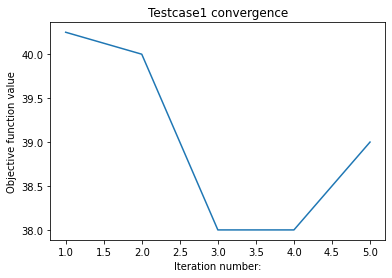

In [ ]:
A = np.array([[10,3], [2,3]])
b = np.array([52,18])
c = np.array([5,6])

# Set of constraints: Ax <= b, to be calculated: min(cx), x- vector of flow variables
# A - LHS coefficients of constraints, b - RHS of constraints, c - objective function coefficients
list1 = []
iter = 0
list2 = []
total = 0
start_time = time.time()
node = bab(A,b,c,[],float('inf'),'max')
total = (total + time.time() - start_time)*100
if node == None:
  print("No feasible integer solution exists")
else:
  print("\nFinal Optimal solution(Integer): ")
  print("\tFlow variables: ",node.flow_var)
  #print("\tObjective function value: ",abs(np.dot(c, np.transpose(node.flow_var))))
  print("\tObjective function value: ",abs(node.obj_func_val))
  print("\nRunning time of branch and bound algorithm: %s ms\n" % total)
  plt.plot(list2,list1)
  plt.title('Testcase1 convergence')
  plt.xlabel('Iteration number:')
  plt.ylabel('Objective function value')
  plt.show()

In [ ]:
A = np.array([[1,5,1], [-1,-2,-1],[-2,-4,-1]])
b = np.array([100,-50,-80])
c = np.array([2,1,2])

# Set of constraints: Ax <= b, to be calculated: min(cx), x- vector of flow variables
# A - LHS coefficients of constraints, b - RHS of constraints, c - objective function coefficients
total = 0
start_time = time.time()
node = bab(A,b,c,[],float('inf'),'min')
total = (total + time.time() - start_time)*1000
if node == None:
  print("No feasible integer solution exists")
else:
  print("\nFinal Optimal solution(Integer): ")
  print("\tFlow variables: ",node.flow_var)
  #print("\tObjective function value: ",abs(np.dot(c, np.transpose(node.flow_var))))
  print("\tObjective function value: ",abs(node.obj_func_val))
  print("\nRunning time of branch and bound algorithm: %s ms\n" % total)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.



Final Optimal solution(Integer): 
	Flow variables:  [14. 16.  4.]
	Objective function value:  51.99999943946539

Running time of branch and bound algorithm: 319.29540634155273 ms




Final Optimal solution(Integer): 
	Flow variables:  [15.  0.  1. 17.  0.]
	Objective function value:  150.99999999507497

Running time: 163.19036483764648 ms



/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


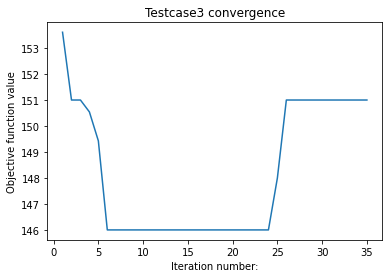

In [ ]:
A = np.array([[5,8,3,2,7],[1,8,6,5,4]])
b = np.array([112,109])
c = np.array([4,7,6,5,4])

list1 = []
iter = 0
list2 = []
total = 0
start_time = time.time()
node = bab(A,b,c,[],float('inf'),'max')
total = (total + time.time() - start_time)*1000
if node == None:
  print("No feasible integer solution exists")
else:
  print("\nFinal Optimal solution(Integer): ")
  print("\tFlow variables: ",node.flow_var)
  #print("\tObjective function value: ",abs(np.dot(c, np.transpose(node.flow_var))))
  print("\tObjective function value: ",abs(node.obj_func_val))
  print("\nRunning time: %s ms\n" % total)
  plt.plot(list2,list1)
  plt.title('Testcase3 convergence')
  plt.xlabel('Iteration number:')
  plt.ylabel('Objective function value')
  plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: OptimizeWarning: Solving system with option 'sym_pos':True 


Final Optimal solution(Integer): 
	Flow variables:  [0. 1. 0. 0. 0. 0. 0. 1. 0.]
	Objective function value:  20.000000000244405

Running time of branch and bound algorithm: 30.0137996673584 ms



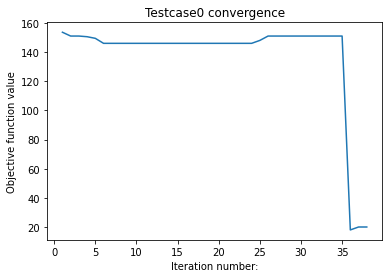

In [ ]:
A = np.array([[-1,-1,-1,0,0,0,-1,0,0], 
              [0,0,-1,-1,-1,0,0,-1,0], 
              [-1,0,0,-1,0,-1,0,-1,0], 
              [-1,-1,0,0,-1,-1,0,0,-1], 
              [0,-1,-1,-1,-1,-1,0,0,-1],
              [1,0,0,0,0,0,0,0,0],
              [0,1,0,0,0,0,0,0,0],
              [0,0,1,0,0,0,0,0,0],
              [0,0,0,1,0,0,0,0,0],
              [0,0,0,0,1,0,0,0,0],
              [0,0,0,0,0,1,0,0,0],
              [0,0,0,0,0,0,1,0,0],
              [0,0,0,0,0,0,0,1,0],
              [0,0,0,0,0,0,0,0,1]])
b = np.array([-1,-1,-1,-1,-1,1,1,1,1,1,1,1,1,1])
c = np.array([10,12,12,13,11,9,7,8,8])

total = 0
start_time = time.time()
node = bab(A,b,c,[],float('inf'),'min')
total = (total + time.time() - start_time)*1000
if node == None:
  print("No feasible integer solution exists")
else:
  print("\nFinal Optimal solution(Integer): ")
  print("\tFlow variables: ",node.flow_var)
  #print("\tObjective function value: ",abs(np.dot(c, np.transpose(node.flow_var))))
  print("\tObjective function value: ",abs(node.obj_func_val))
  print("\nRunning time of branch and bound algorithm: %s ms\n" % total)
  plt.plot(list2,list1)
  plt.title('Testcase0 convergence')
  plt.xlabel('Iteration number:')
  plt.ylabel('Objective function value')
  plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.



Final Optimal solution(Integer): 
	Flow variables:  [1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
	Objective function value:  3.0000000000082103

Running time of branch and bound algorithm: 63.85302543640137 ms



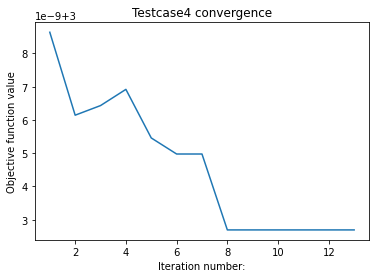

In [ ]:
A = np.array([[-1,-1,-1,-1,0,0,0,0,0,0,0],
              [-1,-1,-1,0,-1,0,0,0,0,0,0],
              [-1,-1,-1,-1,-1,-1,0,0,0,0,0],
              [-1,0,-1,-1,0,-1,-1,0,0,0,0],
              [0,-1,-1,0,-1,-1,0,-1,-1,0,0],
              [0,0,-1,-1,-1,-1,-1,-1,0,0,0],
              [0,0,0,-1,0,-1,-1,-1,0,0,0],
              [0,0,0,0,-1,-1,-1,-1,-1,-1,0],
              [0,0,0,0,-1,0,0,-1,-1,-1,-1],
              [0,0,0,0,0,0,0,-1,-1,-1,-1],
              [0,0,0,0,0,0,0,0,-1,-1,-1],
              [1,0,0,0,0,0,0,0,0,0,0],
              [0,1,0,0,0,0,0,0,0,0,0],
              [0,0,1,0,0,0,0,0,0,0,0],
              [0,0,0,1,0,0,0,0,0,0,0],
              [0,0,0,0,1,0,0,0,0,0,0],
              [0,0,0,0,0,1,0,0,0,0,0],
              [0,0,0,0,0,0,1,0,0,0,0],
              [0,0,0,0,0,0,0,1,0,0,0],
              [0,0,0,0,0,0,0,0,1,0,0],
              [0,0,0,0,0,0,0,0,0,1,0],
              [0,0,0,0,0,0,0,0,0,0,1]])
b = np.array([-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,1,1,1,1,1])
c = np.array([1,1,1,1,1,1,1,1,1,1,1])
list1 = []
iter = 0
list2 = []
total = 0
start_time = time.time()
node = bab(A,b,c,[],float('inf'),'min')
total = (total + time.time() - start_time)*1000
if node == None:
  print("No feasible integer solution exists")
else:
  print("\nFinal Optimal solution(Integer): ")
  print("\tFlow variables: ",node.flow_var)
  #print("\tObjective function value: ",abs(np.dot(c, np.transpose(node.flow_var))))
  print("\tObjective function value: ",abs(node.obj_func_val))
  print("\nRunning time of branch and bound algorithm: %s ms\n" % total)
  plt.plot(list2,list1)
  plt.title('Testcase4 convergence')
  plt.xlabel('Iteration number:')
  plt.ylabel('Objective function value')
  plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.



Final Optimal solution(Integer): 
	Flow variables:  [0. 1. 1. 1.]
	Objective function value:  21.0

Running time of branch and bound algorithm: 59.508323669433594 ms



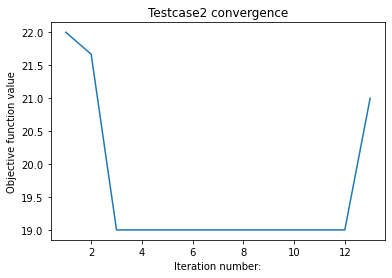

In [ ]:
A = np.array([[5,7,4,3],
              [1,0,0,0],
              [0,1,0,0],
              [0,0,1,0],
              [0,0,0,1]])
b = np.array([14,1,1,1,1])
c = np.array([8,11,6,4])
list1 = []
iter = 0
list2 = []
total = 0
start_time = time.time()
node = bab(A,b,c,[],float('inf'),'max')
total = (total + time.time() - start_time)*1000
if node == None:
  print("No feasible integer solution exists")
else:
  print("\nFinal Optimal solution(Integer): ")
  print("\tFlow variables: ",node.flow_var)
  #print("\tObjective function value: ",abs(np.dot(c, np.transpose(node.flow_var))))
  print("\tObjective function value: ",abs(node.obj_func_val))
  print("\nRunning time of branch and bound algorithm: %s ms\n" % total)
  plt.plot(list2,list1)
  plt.title('Testcase2 convergence')
  plt.xlabel('Iteration number:')
  plt.ylabel('Objective function value')
  plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option


Final Optimal solution(Integer): 
	Flow variables:  [0. 0. 2. 0. 0. 0. 0. 1. 0.]
	Objective function value:  15.0

Running time of branch and bound algorithm: 8.493185043334961 ms



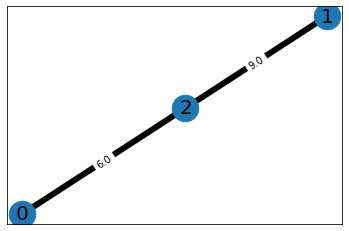

In [ ]:
num_cities = 3
coordinates = np.random.rand(num_cities,2)
demand = [num_cities-1]
for i in range(num_cities-1):
  demand.append(-1)
demand = np.array(demand)
p1 = network_top(num_cities,coordinates,demand)

A = lhs_constraints(num_cities)
b = rhs_constraints(demand,num_cities)

weights = np.zeros((num_cities, num_cities))

for i in range(num_cities):
  j= i+1
  while (j<num_cities):
    temp = random.randint(1, num_cities*5)
    weights[i][j] = temp
    weights[j][i] = temp
    j = j+1

weights = np.array([[ 0., 16.,  3.],[16.,  0.,  9.],[ 3.,  9.,  0.]])

c = np.asarray(weights.flatten())

total = 0
start_time = time.time()
node = bab(A,b,c,[],float('inf'),'min')
total = (total + time.time() - start_time)*1000
if node == None:
  print("No feasible integer solution exists")
else:
  print("\nFinal Optimal solution(Integer): ")
  opt_x = node.flow_var
  print("\tFlow variables: ",opt_x)
  opt_val = abs(np.dot(c, np.transpose(node.flow_var)))
  print("\tObjective function value: ",opt_val)
  print("\nRunning time of branch and bound algorithm: %s ms\n" % total)

  opt_x = np.array(opt_x)
  opt_x = opt_x.reshape((num_cities, num_cities))
  plot(num_cities,weights,opt_x)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.



Final Optimal solution(Integer): 
	Flow variables:  [0. 0. 2. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
	Objective function value:  20.0

Running time of branch and bound algorithm: 7.377147674560547 ms



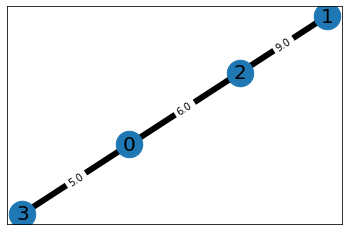

In [ ]:
num_cities = 4
coordinates = np.random.rand(num_cities,2)
demand = [num_cities-1]
for i in range(num_cities-1):
  demand.append(-1)
demand = np.array(demand)
p1 = network_top(num_cities,coordinates,demand)

A = lhs_constraints(num_cities)
b = rhs_constraints(demand,num_cities)

weights = np.zeros((num_cities, num_cities))

for i in range(num_cities):
  j= i+1
  while (j<num_cities):
    temp = random.randint(1, num_cities*5)
    weights[i][j] = temp
    weights[j][i] = temp
    j = j+1

weights = np.array([[ 0., 16.,  3. , 5.],
 [16. , 0.,  9. ,10.],
 [ 3.,  9. , 0.,  3.],
 [ 5., 10.,  3. , 0.]])

c = np.asarray(weights.flatten())

total = 0
start_time = time.time()
node = bab(A,b,c,[],float('inf'),'min')
total = (total + time.time() - start_time)*1000
if node == None:
  print("No feasible integer solution exists")
else:
  print("\nFinal Optimal solution(Integer): ")
  opt_x = node.flow_var
  print("\tFlow variables: ",opt_x)
  opt_val = abs(np.dot(c, np.transpose(node.flow_var)))
  print("\tObjective function value: ",opt_val)
  print("\nRunning time of branch and bound algorithm: %s ms\n" % total)

  opt_x = np.array(opt_x)
  opt_x = opt_x.reshape((num_cities, num_cities))
  plot(num_cities,weights,opt_x)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.



Final Optimal solution(Integer): 
	Flow variables:  [0. 0. 0. 1. 3. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0.
 0.]
	Objective function value:  22.0

Running time of branch and bound algorithm: 12.70747184753418 ms



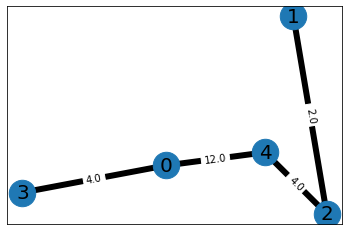

In [ ]:
num_cities = 5
coordinates = np.random.rand(num_cities,2)
demand = [num_cities-1]
for i in range(num_cities-1):
  demand.append(-1)
demand = np.array(demand)
p1 = network_top(num_cities,coordinates,demand)

A = lhs_constraints(num_cities)
b = rhs_constraints(demand,num_cities)

weights = np.zeros((num_cities, num_cities))

for i in range(num_cities):
  j= i+1
  while (j<num_cities):
    temp = random.randint(1, num_cities*5)
    weights[i][j] = temp
    weights[j][i] = temp
    j = j+1

weights = np.array([[ 0., 21.,19.,  4.,  4.],
 [21.,  0.,  2., 25.,  7.],
 [19.,  2.,  0., 14.,  2.],
 [ 4., 25., 14.,  0., 15.],
 [ 4.,  7.,  2., 15.,  0.]])

c = np.asarray(weights.flatten())

total = 0
start_time = time.time()
node = bab(A,b,c,[],float('inf'),'min')
total = (total + time.time() - start_time)*1000
if node == None:
  print("No feasible integer solution exists")
else:
  print("\nFinal Optimal solution(Integer): ")
  opt_x = node.flow_var
  print("\tFlow variables: ",opt_x)
  opt_val = abs(np.dot(c, np.transpose(node.flow_var)))
  print("\tObjective function value: ",opt_val)
  print("\nRunning time of branch and bound algorithm: %s ms\n" % total)

  opt_x = np.array(opt_x)
  opt_x = opt_x.reshape((num_cities, num_cities))
  plot(num_cities,weights,opt_x)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option


Final Optimal solution(Integer): 
	Flow variables:  [0. 0. 4. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	Objective function value:  77.0

Running time of branch and bound algorithm: 45.03202438354492 ms



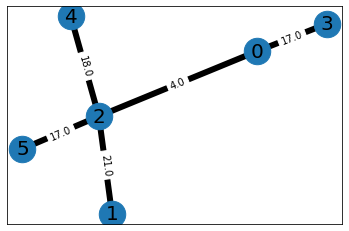

In [ ]:
num_cities = 6
coordinates = np.random.rand(num_cities,2)
demand = [num_cities-1]
for i in range(num_cities-1):
  demand.append(-1)
demand = np.array(demand)
p1 = network_top(num_cities,coordinates,demand)

A = lhs_constraints(num_cities)
b = rhs_constraints(demand,num_cities)

weights = np.zeros((num_cities, num_cities))

for i in range(num_cities):
  j= i+1
  while (j<num_cities):
    temp = random.randint(1, num_cities*5)
    weights[i][j] = temp
    weights[j][i] = temp
    j = j+1

weights = np.array([[ 0., 25.,  1., 17., 27., 18.],
 [25.,  0., 21., 13., 18., 23.],
 [ 1.,21.,  0., 29., 18., 17.],
 [17., 13., 29.,  0., 20., 13.],
 [27., 18., 18., 20.,  0., 17.],
 [18., 23., 17., 13., 17.,  0.]])



c = np.asarray(weights.flatten())

total = 0
start_time = time.time()
node = bab(A,b,c,[],float('inf'),'min')
total = (total + time.time() - start_time)*1000
if node == None:
  print("No feasible integer solution exists")
else:
  print("\nFinal Optimal solution(Integer): ")
  opt_x = node.flow_var
  print("\tFlow variables: ",opt_x)
  opt_val = abs(np.dot(c, np.transpose(node.flow_var)))
  print("\tObjective function value: ",opt_val)
  print("\nRunning time of branch and bound algorithm: %s ms\n" % total)

  opt_x = np.array(opt_x)
  opt_x = opt_x.reshape((num_cities, num_cities))
  plot(num_cities,weights,opt_x)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option


Final Optimal solution(Integer): 
	Flow variables:  [0. 3. 0. 0. 3. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
	Objective function value:  99.0

Running time of branch and bound algorithm: 365.1692867279053 ms



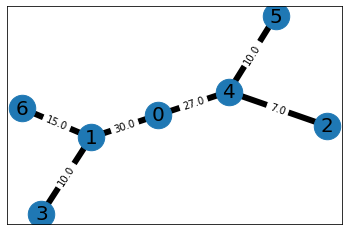

In [ ]:
num_cities = 7
coordinates = np.random.rand(num_cities,2)
demand = [num_cities-1]
for i in range(num_cities-1):
  demand.append(-1)
demand = np.array(demand)
p1 = network_top(num_cities,coordinates,demand)

A = lhs_constraints(num_cities)
b = rhs_constraints(demand,num_cities)

weights = np.zeros((num_cities, num_cities))

for i in range(num_cities):
  j= i+1
  while (j<num_cities):
    temp = random.randint(1, num_cities*5)
    weights[i][j] = temp
    weights[j][i] = temp
    j = j+1

weights = np.array([[0., 10., 34., 28.,  9., 19., 27.],
 [10.,  0., 23., 10., 32., 20., 15.],
 [34., 23.,  0., 22.,  7., 18.,  9.],
 [28., 10., 22.,  0., 25., 31.,  8.],
 [ 9., 32.,  7., 25.,  0., 10., 27.],
 [19., 20., 18., 31., 10.,  0., 25.],
 [27., 15.,  9.,  8., 27., 25.,  0.]])

c = np.asarray(weights.flatten())

total = 0
start_time = time.time()
node = bab(A,b,c,[],float('inf'),'min')
total = (total + time.time() - start_time)*1000
if node == None:
  print("No feasible integer solution exists")
else:
  print("\nFinal Optimal solution(Integer): ")
  opt_x = node.flow_var
  print("\tFlow variables: ",opt_x)
  opt_val = abs(np.dot(c, np.transpose(node.flow_var)))
  print("\tObjective function value: ",opt_val)
  print("\nRunning time of branch and bound algorithm: %s ms\n" % total)

  opt_x = np.array(opt_x)
  opt_x = opt_x.reshape((num_cities, num_cities))
  plot(num_cities,weights,opt_x)



/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.



Final Optimal solution(Integer): 
	Flow variables:  [0. 0. 2. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 1. 0. 0. 3. 0.]
	Objective function value:  86.0

Running time of branch and bound algorithm: 16.971826553344727 ms



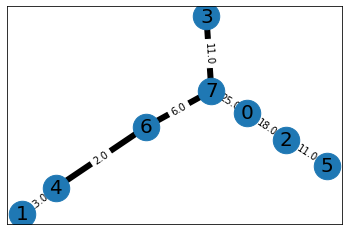

In [ ]:
num_cities = 8
coordinates = np.random.rand(num_cities,2)
demand = [num_cities-1]
for i in range(num_cities-1):
  demand.append(-1)
demand = np.array(demand)
p1 = network_top(num_cities,coordinates,demand)

A = lhs_constraints(num_cities)
b = rhs_constraints(demand,num_cities)

weights = np.zeros((num_cities, num_cities))

for i in range(num_cities):
  j= i+1
  while (j<num_cities):
    temp = random.randint(1, num_cities*5)
    weights[i][j] = temp
    weights[j][i] = temp
    j = j+1

weights = np.array([[ 0., 35.,  9., 39., 21., 23., 19.,  5.],
 					[35.,  0., 29., 40., 13., 37., 40., 36.],
 					[ 9., 29.,  0., 22.,  4., 11., 38.,  6.],
 					[39., 40., 22.,  0., 31.,  8., 34., 11.],
 					[21., 13.,  4., 31.,  0., 21.,  1., 14.],
 					[23., 37., 11.,  8., 21.,  0., 29., 20.],
 					[19., 40., 38., 34.,  1., 29.,  0.,  2.],
 					[ 5., 36.,  6., 11., 14., 20.,  2.,  0.]])

c = np.asarray(weights.flatten())

total = 0
start_time = time.time()
node = bab(A,b,c,[],float('inf'),'min')
total = (total + time.time() - start_time)*1000
if node == None:
  print("No feasible integer solution exists")
else:
  print("\nFinal Optimal solution(Integer): ")
  opt_x = node.flow_var
  print("\tFlow variables: ",opt_x)
  opt_val = abs(np.dot(c, np.transpose(node.flow_var)))
  print("\tObjective function value: ",opt_val)
  print("\nRunning time of branch and bound algorithm: %s ms\n" % total)

  opt_x = np.array(opt_x)
  opt_x = opt_x.reshape((num_cities, num_cities))
  plot(num_cities,weights,opt_x)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: OptimizeWarning: Solving system with option 'sym_pos':True 


Final Optimal solution(Integer): 
	Flow variables:  [0. 1. 0. 0. 0. 0. 6. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 2. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	Objective function value:  124.0

Running time of branch and bound algorithm: 98.63042831420898 ms



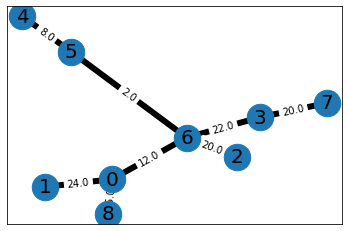

In [ ]:
num_cities = 9
coordinates = np.random.rand(num_cities,2)
demand = [num_cities-1]
for i in range(num_cities-1):
  demand.append(-1)
demand = np.array(demand)
p1 = network_top(num_cities,coordinates,demand)

A = lhs_constraints(num_cities)
b = rhs_constraints(demand,num_cities)

weights = np.zeros((num_cities, num_cities))

for i in range(num_cities):
  j= i+1
  while (j<num_cities):
    temp = random.randint(1, num_cities*5)
    weights[i][j] = temp
    weights[j][i] = temp
    j = j+1

weights = np.array([[ 0., 24., 27., 42., 12., 30.,  2., 40., 16.],
 					[24.,  0., 17., 39., 45., 26., 39., 24., 41.],
 					[27., 17.,  0., 41., 18., 30., 20., 17., 23.],
 					[42., 39., 41.,  0., 29., 40., 11., 20.,  3.],
 					[12., 45., 18., 29.,  0.,  8., 36., 27., 45.],
 					[30., 26., 30., 40.,  8.,  0.,  1., 35., 44.],
 					[ 2., 39., 20., 11., 36.,  1., 0. ,40. ,20.],
 					[40., 24., 17., 20., 27., 35., 40.,  0. ,19.],
 					[16., 41., 23.,  3., 45., 44., 20., 19.  ,0.]])

c = np.asarray(weights.flatten())

total = 0
start_time = time.time()
node = bab(A,b,c,[],float('inf'),'min')
total = (total + time.time() - start_time)*1000
if node == None:
  print("No feasible integer solution exists")
else:
  print("\nFinal Optimal solution(Integer): ")
  opt_x = node.flow_var
  print("\tFlow variables: ",opt_x)
  opt_val = abs(np.dot(c, np.transpose(node.flow_var)))
  print("\tObjective function value: ",opt_val)
  print("\nRunning time of branch and bound algorithm: %s ms\n" % total)

  opt_x = np.array(opt_x)
  opt_x = opt_x.reshape((num_cities, num_cities))
  plot(num_cities,weights,opt_x)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option


Final Optimal solution(Integer): 
	Flow variables:  [0. 7. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 4. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
	Objective function value:  125.0

Running time of branch and bound algorithm: 120.48697471618652 ms



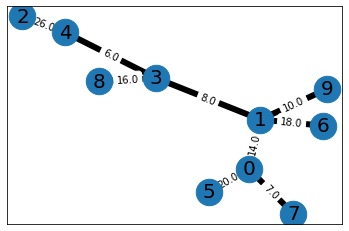

In [ ]:
num_cities = 10
coordinates = np.random.rand(num_cities,2)
demand = [num_cities-1]
for i in range(num_cities-1):
  demand.append(-1)
demand = np.array(demand)
p1 = network_top(num_cities,coordinates,demand)

A = lhs_constraints(num_cities)
b = rhs_constraints(demand,num_cities)

weights = np.zeros((num_cities, num_cities))

for i in range(num_cities):
  j= i+1
  while (j<num_cities):
    temp = random.randint(1, num_cities*5)
    weights[i][j] = temp
    weights[j][i] = temp
    j = j+1
#print(weights)
weights = np.array([[ 0. , 2., 34., 12., 48., 20., 40. , 7., 46., 33.],
 					[ 2.,  0., 42.,  2., 41., 31., 18., 50., 26., 10.],
 					[34., 42.,  0., 48., 26., 18., 15., 44., 20., 32.],
 					[12.,  2. ,48.,  0.,  3., 32., 31., 44., 16., 28.],
 					[48., 41., 26.,  3.,  0., 28., 26., 23., 42., 33.],
 					[20., 31., 18., 32., 28.,  0., 22., 26., 45., 40.],
 					[40., 18., 15., 31., 26., 22.,  0., 27.,  1., 46.],
 					[ 7., 50., 44., 44., 23., 26., 27.,  0., 20., 23.],
 					[46., 26., 20., 16., 42., 45.,  1., 20.,  0., 16.],
 					[33., 10., 32., 28., 33., 40., 46., 23., 16.,  0.]])
c = np.asarray(weights.flatten())

total = 0
start_time = time.time()
node = bab(A,b,c,[],float('inf'),'min')
total = (total + time.time() - start_time)*1000
if node == None:
  print("No feasible integer solution exists")
else:
  print("\nFinal Optimal solution(Integer): ")
  opt_x = node.flow_var
  print("\tFlow variables: ",opt_x)
  opt_val = abs(np.dot(c, np.transpose(node.flow_var)))
  print("\tObjective function value: ",opt_val)
  print("\nRunning time of branch and bound algorithm: %s ms\n" % total)

  opt_x = np.array(opt_x)
  opt_x = opt_x.reshape((num_cities, num_cities))
  plot(num_cities,weights,opt_x)
